In [1]:
from IPython.display import Audio

import torch
import torch.nn as nn
import torchaudio
from utils import *
import math
from model import Wav2Vec2ForPreTraining,Wav2Vec2Config,Wav2Vec2FeatureExtractor

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
x = []
for i in range(1,3):
    path = f"data/mp3_train_files/Gould/Gould - WTC_clip_{i}.mp3"
    waveform,sample_rate = torchaudio.load(path)
    waveform = torch.mean(waveform, dim=0).unsqueeze(0)
    waveform = normalize_tensor(waveform)
    x.append(waveform)


x = torch.cat(x)

x.shape

torch.Size([2, 220500])

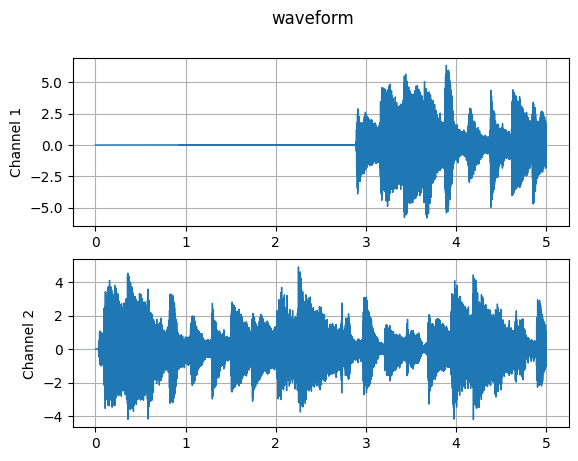

In [3]:
plot_waveform(x, sample_rate)

In [4]:
dim = 512 # quadratic to number of params in conv... double dim quadruple params

conv_feature_layers = (
    [(dim, 10, 2)] * 3 + [(dim, 3, 2)] * 5 + [(dim, 2, 2)] + [(dim, 2, 2)]
)  # (dim,kernel width, strides) # kernel_width is window, string is len of slide
conv_feature_layers = [(dim, 10, 5)] + [(dim, 3, 2)] * 4 + [(dim, 2, 2)] + [(dim, 2, 2)]
receptive_field = calculate_receptive_field(conv_feature_layers)
print(f"{receptive_field=} samples")
print(f"{round(receptive_field / (sample_rate / 1000),3)} ms")

receptive_field=400 samples
9.07 ms


In [15]:
feature_extractor = Wav2Vec2FeatureExtractor(conv_feature_layers, mode="default",dropout=0.0,conv_bias=False)
print('input shape=',x.shape)
conv_out = feature_extractor(x, verbose=True)
print("output shape= ", conv_out['input_values'][0].shape)

input shape= torch.Size([2, 220500])
output shape=  (2, 220500)


In [17]:
features = conv_out['input_values'][0].transpose(1, 2)
print(features.shape)

AxisError: axis 2 is out of bounds for array of dimension 2

In [7]:
# regular layer norm
ln = torch.nn.LayerNorm(dim, 1e-5, elementwise_affine=True)
features = ln(features)
print(features.shape)

torch.Size([2, 688, 512])


In [8]:
features.shape

torch.Size([2, 688, 512])

In [9]:
dropout_input = nn.Dropout(0.0)
dropout_features = nn.Dropout(0.0)

features = dropout_input(features)
unmasked_features = dropout_features(features)

In [10]:
latent_vars = 320
temp_default = (2, 0.5, 0.999995)
groups = 2
vq_dim = 768 # output_dim? to match input of attn
weight_proj_factor = 3
gum = GumbelVectorQuantizer(
    dim=dim,
    num_vars=latent_vars,
    temp=temp_default,
    combine_groups=False,
    groups=groups,
    vq_dim=vq_dim,
    time_first=True,
    weight_proj_depth=1,
    weight_proj_factor=weight_proj_factor,
)

In [11]:
gum

GumbelVectorQuantizer(
  (weight_proj): Linear(in_features=512, out_features=640, bias=True)
)

In [12]:
q  = gum(features, produce_targets=False)

features = q["x"]
num_vars = q["num_vars"]
code_ppl = q["code_perplexity"]
prob_ppl = q["prob_perplexity"]
curr_temp = q["temp"]

project_inp = nn.Linear(vq_dim,768)

feature = project_inp(features)

In [13]:
features.shape

torch.Size([2, 688, 768])

In [14]:
from fairseq.models.wav2vec import ConformerEncoder
from fairseq.models.wav2vec import Wav2Vec2Config

cfg = Wav2Vec2Config()
cfg.pos_enc_type = "rope"
encoder = ConformerEncoder
encoder = encoder(cfg)
x, layer_results = encoder(features,padding_mask=None,layer=None)
y = unmasked_features

/home/luke/projects/jupyterlab/Notebooks/song2vec/venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [15]:
# after transformer layer
q = gum(y, produce_targets=False)
y = q["x"]
num_vars = q["num_vars"]
code_ppl = q["code_perplexity"]
prob_ppl = q["prob_perplexity"]
curr_temp = q["temp"]

project_q = nn.Linear(768,768)
y = project_q(y)

In [16]:
from utils import sample_negatives

negs, _ = sample_negatives(
    y,
    y.size(1),
    padding_count=None,
)

TypeError: sample_negatives() missing 1 required positional argument: 'num'

# break

In [152]:
import torch
from transformers import AutoFeatureExtractor, Wav2Vec2ForPreTraining,Wav2Vec2Config
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    _compute_mask_indices,
    _sample_negative_indices,
)
from datasets import load_dataset

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")


config = Wav2Vec2Config()
config.activation_dropout = 0.101

model = Wav2Vec2ForPreTraining(config)

/home/luke/projects/jupyterlab/Notebooks/song2vec/venv/lib/python3.10/site-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [153]:
model

Wav2Vec2ForPreTraining(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (

In [154]:
ds = load_dataset(
    "hf-internal-testing/librispeech_asr_dummy", "clean", split="validation"
)
input_values = feature_extractor(
    ds[0]["audio"]["array"], return_tensors="pt"
).input_values

/home/luke/projects/jupyterlab/Notebooks/song2vec/venv/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for hf-internal-testing/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [155]:
batch_size, raw_sequence_length = input_values.shape
sequence_length = model._get_feat_extract_output_lengths(raw_sequence_length).item()

In [156]:
mask_time_indices = _compute_mask_indices(
    shape=(batch_size, sequence_length), mask_prob=0.2, mask_length=2
)

In [157]:
sampled_negative_indices = _sample_negative_indices(
    features_shape=(batch_size, sequence_length),
    num_negatives=model.config.num_negatives,
    mask_time_indices=mask_time_indices,
)

In [158]:
mask_time_indices = torch.tensor(
    data=mask_time_indices, device=input_values.device, dtype=torch.long
)
sampled_negative_indices = torch.tensor(
    data=sampled_negative_indices, device=input_values.device, dtype=torch.long
)

In [159]:
sampled_negative_indices

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [167]:
with torch.no_grad():
    outputs = model(input_values, mask_time_indices=mask_time_indices)

In [168]:
cosine_sim = torch.cosine_similarity(
    outputs.projected_states, outputs.projected_quantized_states, dim=-1
)

In [169]:
cosine_sim[mask_time_indices.to(torch.bool)].mean() > 0.5

tensor(False)

In [185]:
model = model.train()
loss = model(
    input_values,
    mask_time_indices=mask_time_indices,
    sampled_negative_indices=sampled_negative_indices,
).loss

In [186]:
model(
    input_values,
    mask_time_indices=mask_time_indices,
    sampled_negative_indices=sampled_negative_indices,
).loss

tensor(276.4055, grad_fn=<AddBackward0>)

In [187]:
loss.backward()